# **Visualisation**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

**Data loading**

Data frame pour modèles machine learning

In [ ]:
df_IA = pd.read_csv('../data/final_data.zip')

Data frame pour visualisation

In [2]:
df = pd.read_csv('../data/final_data.zip')

C:\Users\eva2p\AppData\Local\Temp\ipykernel_22304\977126207.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/final_data.zip')


In [3]:
df.sample(5)

,ID_ANSSI,Titre,Type,Date,CVE,CVSS,Base Severity,CWE,EPSS,Lien,Description,Éditeur,Produit,Versions affectées,Remote exploitable,Longueur description
203300,CERTFR-2024-AVI-0580,Multiples vulnérabilités dans le noyau Linux d...,Avis,2024-07-12T13:27:19.646180,CVE-2024-27077,NaN,NaN,Non disponible,0.00042,https://www.cert.ssi.gouv.fr/openapi.json,"In the Linux kernel, the following vulnerabili...",Linux,Linux,"4.19, 0, 4.19.311, 5.4.273, 5.10.214, 5.15.153...",False,327.0
142669,CERTFR-2025-AVI-0010,Multiples vulnérabilités dans les produits Splunk,Avis,2025-01-08T08:14:55.345738,CVE-2023-5685,7.5,Élevée,CWE-400,0.00044,https://www.cert.ssi.gouv.fr/openapi.json,A flaw was found in XNIO. The XNIO NotifierSta...,Red Hat,Red Hat build of Apache Camel - HawtIO,NaN,False,239.0
132398,CERTFR-2024-AVI-0681,Multiples vulnérabilités dans Microsoft Windows,Avis,2024-08-14T13:42:38.425864,CVE-2024-38223,6.8,Moyenne,CWE-284,0.00051,https://www.cert.ssi.gouv.fr/openapi.json,Windows Initial Machine Configuration Elevatio...,Microsoft,Windows 10 Version 22H2,10.0.19045.0,False,74.0
96394,CERTFR-2024-AVI-0667,Multiples vulnérabilités dans le noyau Linux d...,Avis,2024-08-09T00:00:00.000000,CVE-2024-38597,NaN,NaN,Non disponible,0.00054,https://www.cert.ssi.gouv.fr/openapi.json,"In the Linux kernel, the following vulnerabili...",Linux,Linux,"fe09bb619096a0aa139210748ddc668c2dbe2308, fe09...",False,701.0
57177,CERTFR-2025-AVI-0435,Multiples vulnérabilités dans les produits Atl...,Avis,2025-05-21T00:00:00.000000,CVE-2025-31650,7.5,Élevée,CWE-459,0.00957,https://www.cert.ssi.gouv.fr/openapi.json,Improper Input Validation vulnerability in Apa...,Apache Software Foundation,Apache Tomcat,"9.0.76, 10.1.10, 11.0.0-M2",False,526.0


In [4]:
df.shape

(225314, 16)

# Data cleaning

Type conversion

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S.%f', errors='coerce')
df["CVSS"] = pd.to_numeric(df["CVSS"], errors="coerce")
df["EPSS"] = pd.to_numeric(df["EPSS"], errors="coerce")

CVSS cleaning

In [6]:
# if less than 10% are empty -> delete, otherwise -> fill
cvss_nan_pct = df["CVSS"].isna().mean()
if cvss_nan_pct < 0.1:
    df = df.dropna(subset=["CVSS"])
else: 
    df["CVSS"] = df["CVSS"].fillna(df["CVSS"].median())
    print("Choice : replacing by median value") #median to avoid outliers

Choice : replacing by median value


EPSS cleaning

In [7]:
epss_nan_pct = df["EPSS"].isna().mean()
if epss_nan_pct < 0.1:
    df = df.dropna(subset=["EPSS"])
else:
    df["EPSS"] = df["EPSS"].fillna(df["EPSS"].median())
    print("Choice : replacing by median value")

In [8]:
df.shape

(224411, 16)

In [9]:
df = df[df["CWE"] != "Non disponible"]

In [10]:
df.shape

(118702, 16)

Base severity

In [11]:
def gravite_from_cvss(cvss):
    if pd.isna(cvss):
        return "Non spécifié"
    if cvss >= 9.0:
        return "Critique"
    elif cvss >= 7.0:
        return "Élevée"
    elif cvss >= 4.0:
        return "Moyenne"
    else:
        return "Faible"

df["Base Severity"] = df["CVSS"].apply(gravite_from_cvss)

Deleting lignes with missing editor or product

In [12]:
df = df[df["Éditeur"].notna() & (df["Éditeur"] != "Non précisé")]
df = df[df["Produit"].notna()]

In [13]:
df.shape

(110770, 16)

# **Visualisation**

**Severity level categorization function**

In [14]:
def cvss_to_severity(score):
    try:
        score = float(score)
        if score <= 3:
            return 'Faible'
        elif score <= 6:
            return 'Moyenne'
        elif score <= 8:
            return 'Élevée'
        else:
            return 'Critique'
    except:
        return 'Inconnu'

# 1. Histogram of severity levels (based on CVSS)

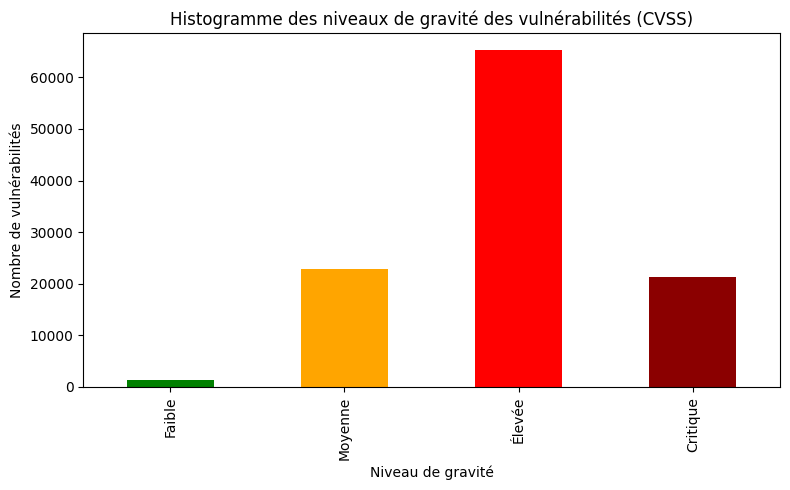

In [15]:
df['Gravité'] = df['CVSS'].apply(cvss_to_severity)
grav_counts = df['Gravité'].value_counts().reindex(['Faible', 'Moyenne', 'Élevée', 'Critique'], fill_value=0)

# Plot
plt.figure(figsize=(8,5))
grav_counts.plot(kind='bar', color=['green', 'orange', 'red', 'darkred', 'gray'])
plt.title('Histogramme des niveaux de gravité des vulnérabilités (CVSS)')
plt.xlabel('Niveau de gravité')
plt.ylabel('Nombre de vulnérabilités')
plt.tight_layout()
plt.show()

# 2. Circular vulnerability diagram (CWE)

Top 10 most frequents, the other gouped by "Others"

In [17]:
top_cwe = df['CWE'].value_counts()
top_18 = top_cwe.head(18)
autres = top_cwe[18:].sum()
top_18['Autres'] = autres

Plot

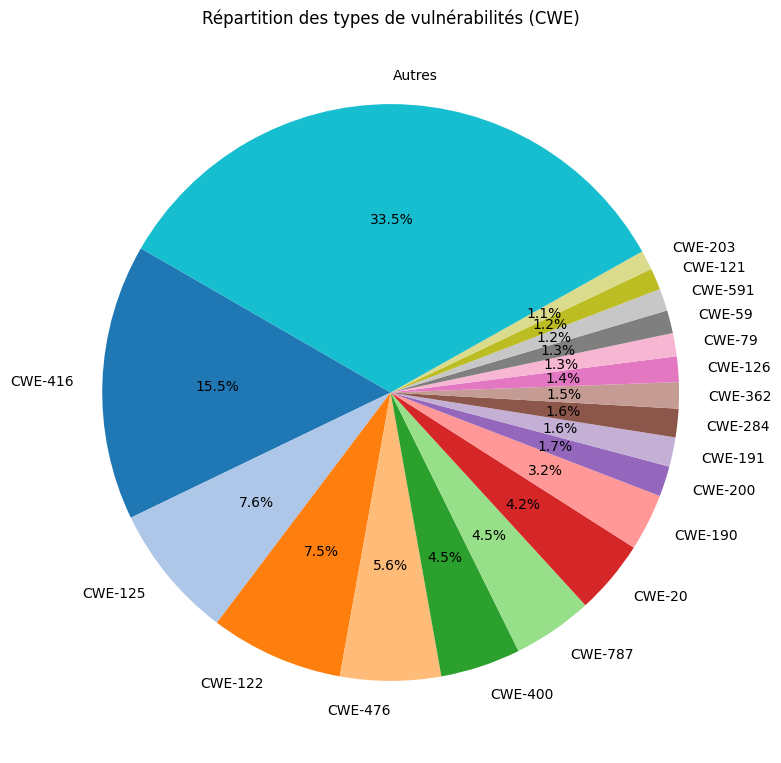

In [18]:
plt.figure(figsize=(8,8))
colors = plt.cm.tab20.colors[:len(top_18)]
top_18.plot(kind='pie', autopct='%1.1f%%', startangle=150, colors=colors)
plt.title('Répartition des types de vulnérabilités (CWE)')
plt.ylabel('')
plt.tight_layout()
plt.show()

# 3. EPSS Score Density Curve

In [58]:
epss = df['EPSS']

Plot

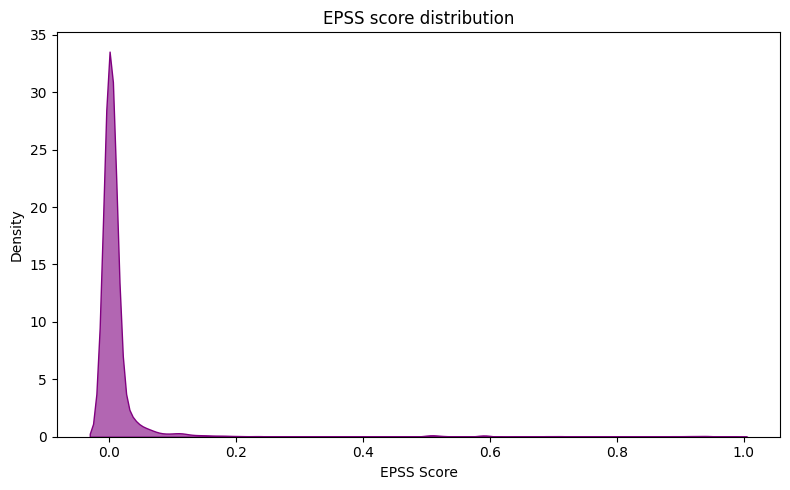

In [59]:
plt.figure(figsize=(8, 5))
sns.kdeplot(epss, fill=True, color="purple", alpha=0.6)
plt.title('EPSS score distribution')
plt.xlabel('EPSS Score')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Zoom on small EPSS Score

In [60]:
epss_filtered = epss[(epss >= 0) & (epss <= 0.10)]

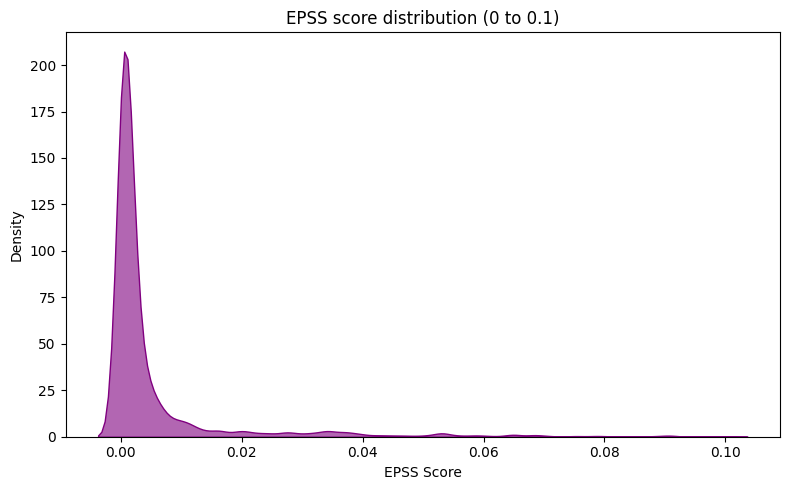

In [61]:
plt.figure(figsize=(8, 5))
sns.kdeplot(epss_filtered, fill=True, color="purple", alpha=0.6)
plt.title('EPSS score distribution (0 to 0.1)')
plt.xlabel('EPSS Score')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# 4. Top Affected editors

Count top 10 most frequently affected editors

In [23]:
top_editors = df['Éditeur'].value_counts().head(10)

Plot

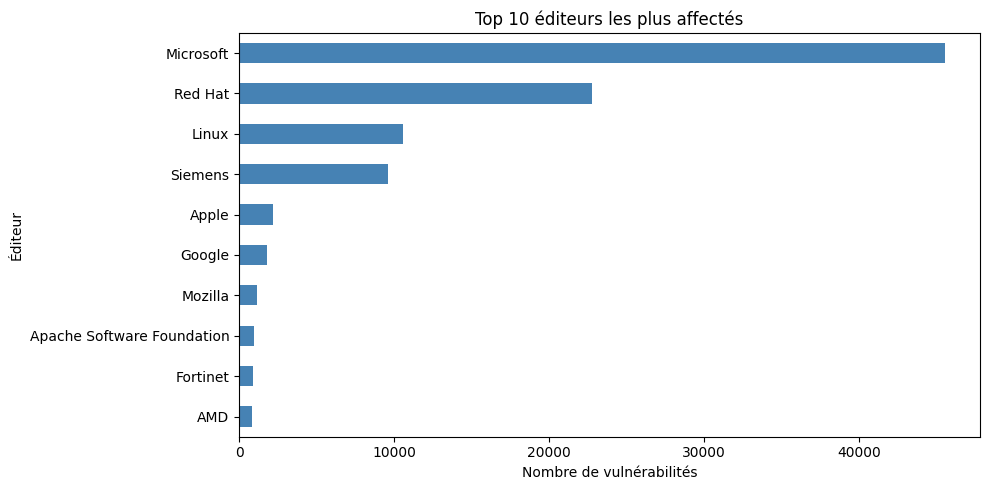

In [24]:
plt.figure(figsize=(10, 5))
top_editors.plot(kind='barh', color='steelblue')
plt.title('Top 10 éditeurs les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 5. Top affected products

Count top 10 most frequently affected products

In [25]:
top_products = df['Produit'].value_counts().head(10)

Plot

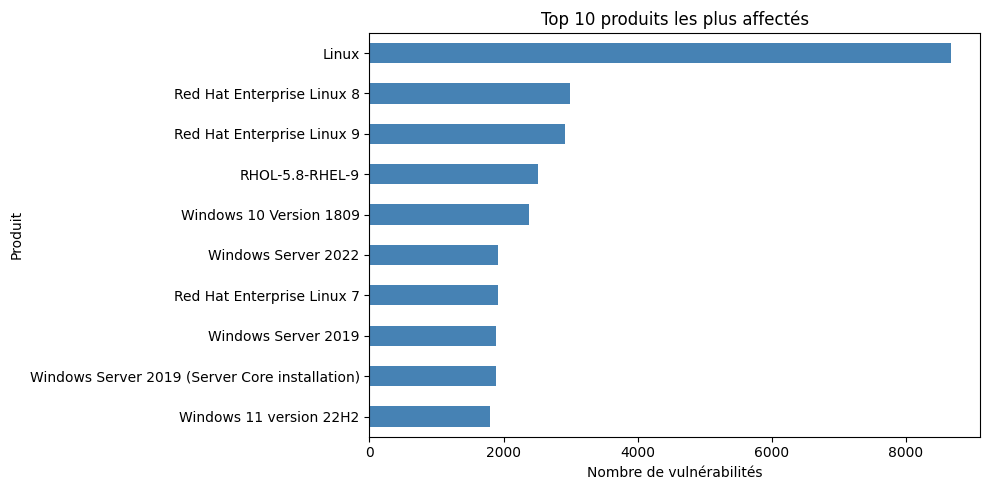

In [26]:
plt.figure(figsize=(10, 5))
top_products.plot(kind='barh', color='steelblue')
plt.title('Top 10 produits les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 6. Heatmap : Correlation between CVSS and EPSS

Create a correlation dataframe

In [27]:
correlation_df = df[["CVSS", "EPSS"]]

In [28]:
df["Gravité_CVSS"] = df["CVSS"].apply(cvss_to_severity)

Categorize EPSS into 4 probability bins

In [29]:
def epss_to_level(epss):
    if epss <= 0.25:
        return "Faible"
    elif epss <= 0.5:
        return "Moyenne"
    elif epss <= 0.75:
        return "Élevée"
    else:
        return "Critique"

In [30]:
df["Probabilité_EPSS"] = df["EPSS"].apply(epss_to_level)

Create heatmap

In [31]:
heatmap_data = pd.crosstab(df["Gravité_CVSS"], df["Probabilité_EPSS"])
heatmap_data = heatmap_data.reindex(index=["Critique", "Élevée", "Moyenne", "Faible"],
                                     columns=["Faible", "Moyenne", "Élevée", "Critique"])

Plot

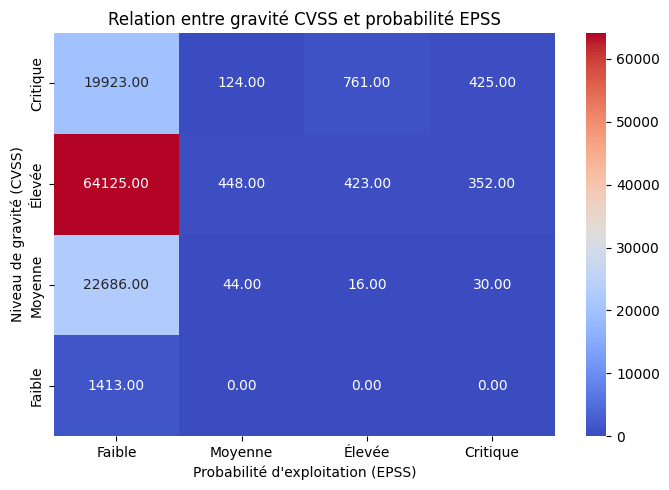

In [32]:
plt.figure(figsize=(7, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Relation entre gravité CVSS et probabilité EPSS")
plt.xlabel("Probabilité d'exploitation (EPSS)")
plt.ylabel("Niveau de gravité (CVSS)")
plt.tight_layout()
plt.show()

# 7. Scatter plot : CVSS vs EPSS

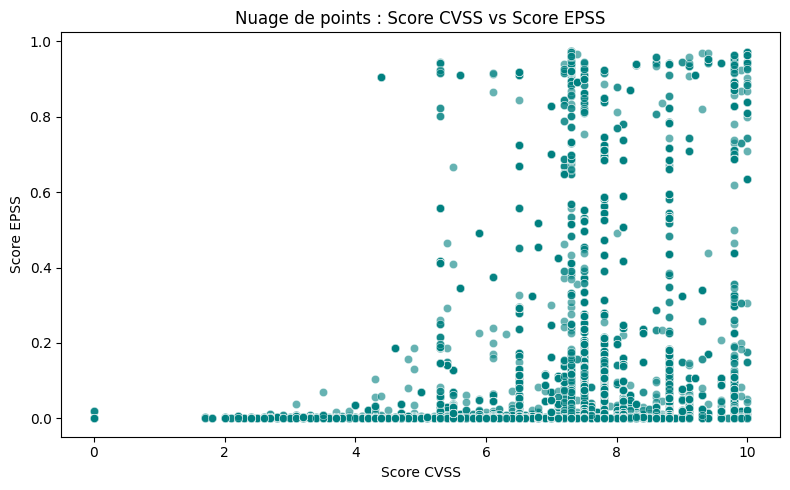

In [33]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="CVSS", y="EPSS", alpha=0.6, color="teal")
plt.title("Nuage de points : Score CVSS vs Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.tight_layout()
plt.show()

# 8. Cumulative curve: Vulnerabilities over time

In [34]:
df_sorted = df.sort_values("Date")

Group by date and calculate cumulative sum

In [35]:
cumulative_df = df_sorted.groupby("Date").size().cumsum()

Plot

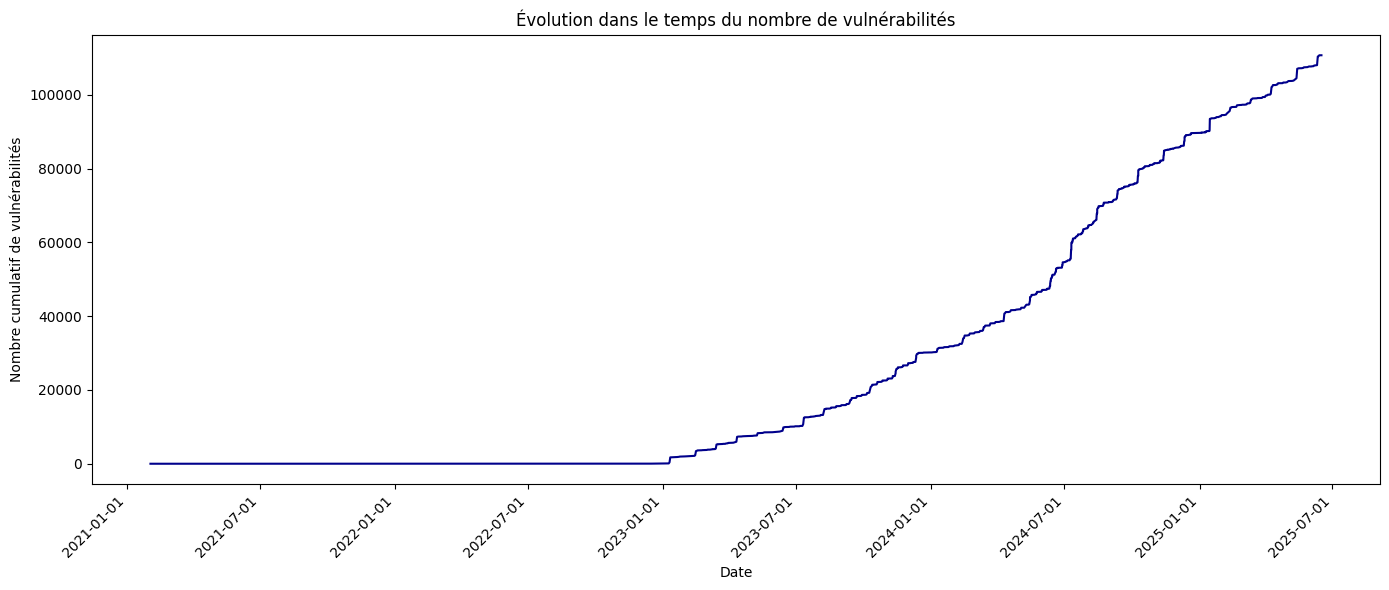

In [36]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(cumulative_df.index, cumulative_df.values, color="darkblue")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.title("Évolution dans le temps du nombre de vulnérabilités")
plt.xlabel("Date")
plt.ylabel("Nombre cumulatif de vulnérabilités")
plt.tight_layout()
plt.show()

# 9. Boxplot : CVSS scores by top editors

Filter

In [37]:
top_editors = df['Éditeur'].value_counts().head(10).index
boxplot_df = df[df['Éditeur'].isin(top_editors)]

Plot

C:\Users\eva2p\AppData\Local\Temp\ipykernel_22304\3526360994.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')


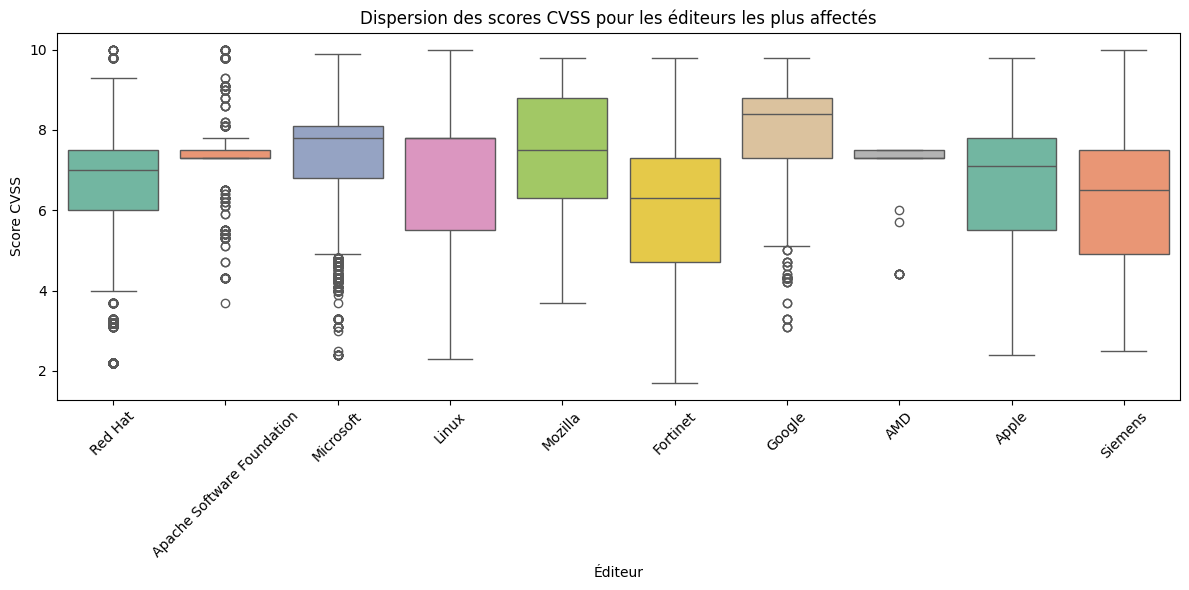

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')
plt.title('Dispersion des scores CVSS pour les éditeurs les plus affectés')
plt.xlabel('Éditeur')
plt.ylabel('Score CVSS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10. Time evolution of CWE-416 vulnerabilities ("Use After Free" : use after freeing of memory)

In [62]:
cwe_416_df = df[df["CWE"] == "CWE-416"]

Group by month

In [63]:
cwe_416_monthly = cwe_416_df.groupby(df["Date"].dt.to_period("M")).size()
cwe_416_monthly.index = cwe_416_monthly.index.to_timestamp()

Plot

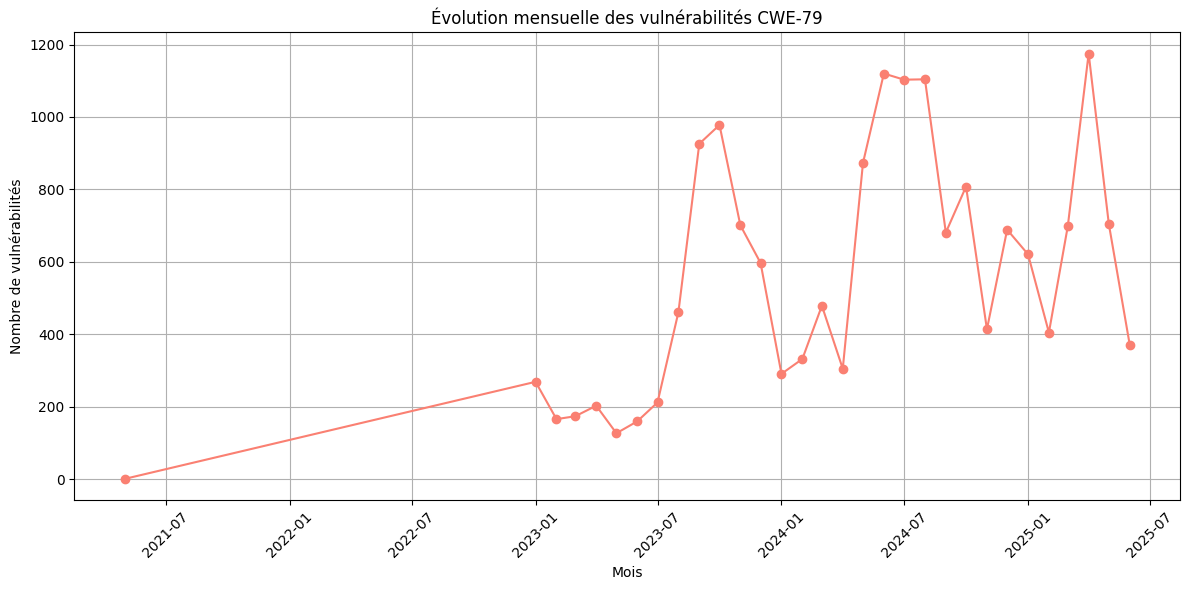

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(cwe_416_monthly.index, cwe_416_monthly.values, marker="o", linestyle="-", color="salmon")
plt.title("Évolution mensuelle des vulnérabilités CWE-79")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Histogram of vulnerabilities by product for CWE-125 : Out-of-bounds Read

Selection of CWE-125

In [42]:
cwe_cible = "CWE-125"
df_cwe = df[df["CWE"] == cwe_cible]

Count vulnerabilities by product

In [43]:
produit_counts = df_cwe["Produit"].value_counts().sort_values(ascending=False).head(15)

Plot

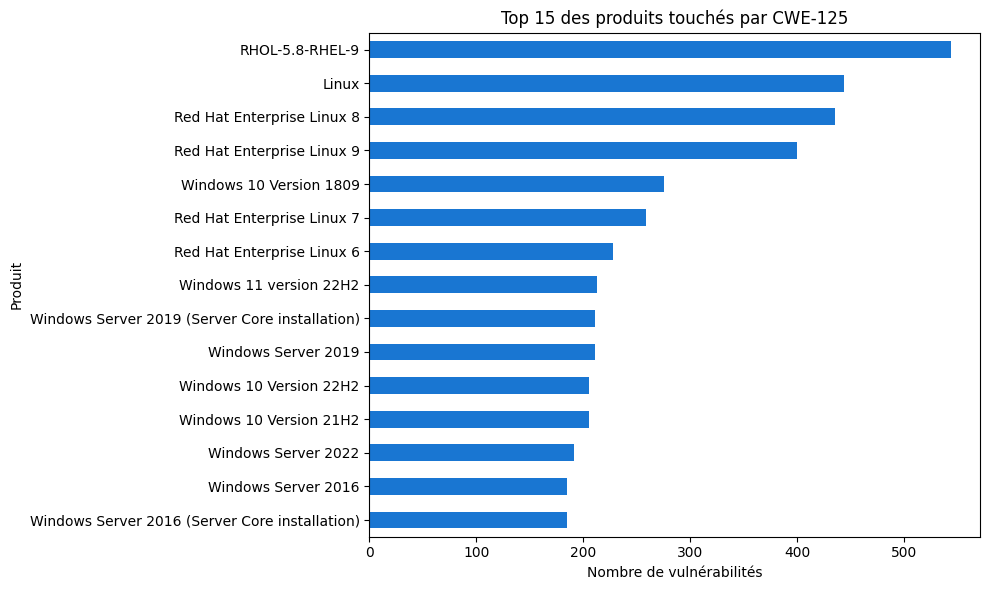

In [44]:
plt.figure(figsize=(10,6))
produit_counts.plot(kind="barh", color="#1976D2")
plt.gca().invert_yaxis()
plt.title(f"Top 15 des produits touchés par {cwe_cible}")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Produit")
plt.tight_layout()
plt.show()

# 12. Heatmap CWE x editor

Heatmap

In [45]:
heatmap_data = pd.crosstab(df["CWE"], df["Éditeur"])

Selection (if not too many values)

In [46]:
top_cwe = heatmap_data.sum(axis=1).sort_values(ascending=False).head(15).index
top_editeurs = heatmap_data.sum(axis=0).sort_values(ascending=False).head(14).index
filtered_data = heatmap_data.loc[top_cwe, top_editeurs]

Plot

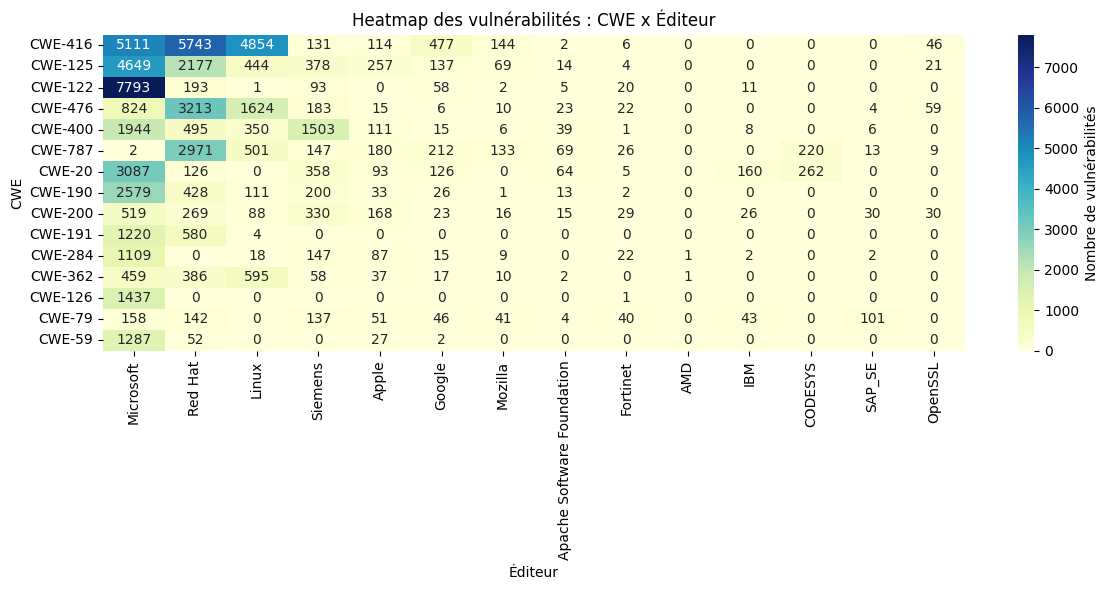

In [47]:
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Nombre de vulnérabilités'})
plt.title("Heatmap des vulnérabilités : CWE x Éditeur")
plt.xlabel("Éditeur")
plt.ylabel("CWE")
plt.tight_layout()
plt.show()

# 13. Monthly vulnerability trends by CWE (superimposed curves)

Extraction of the month and the year

In [48]:
df["Mois"] = df["Date"].dt.to_period("M")  # Format AAAA-MM

Keep only the 8 most frequent CWE

In [49]:
top_cwes = df[df["CWE"] != "Non disponible"]["CWE"].value_counts().head(5).index
df_top = df[df["CWE"].isin(top_cwes)]

Keep only after january 2023

In [50]:
df_top = df_top[df_top["Mois"] >= "2023-01"]

Grouping: number of vulnerabilities per month and per CWE

In [51]:
df_grouped = df_top.groupby(["Mois", "CWE"]).size().unstack(fill_value=0)

Plot

<Figure size 1200x600 with 0 Axes>

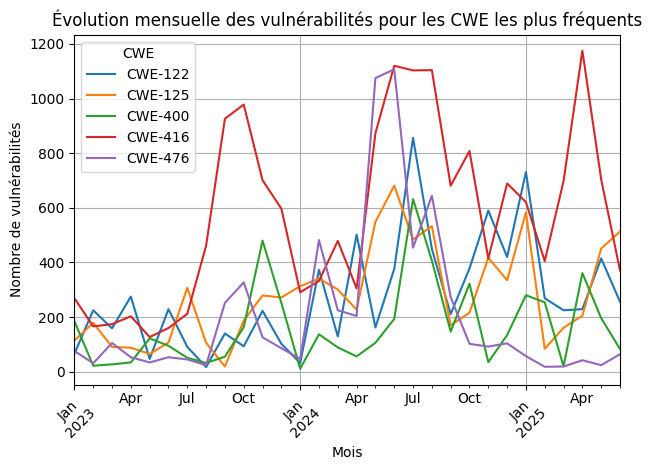

In [52]:
plt.figure(figsize=(12, 6))
df_grouped.plot()
plt.title("Évolution mensuelle des vulnérabilités pour les CWE les plus fréquents")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.legend(title="CWE")
plt.tight_layout()
plt.grid(True)
plt.show()

# 14. Heatmap : temporal vunerabilities

In [53]:
df["Année"] = df["Date"].dt.year
df["Mois"] = df["Date"].dt.month

In [54]:
pivot = pd.crosstab(df["Année"], df["Mois"]).fillna(0)

Plot

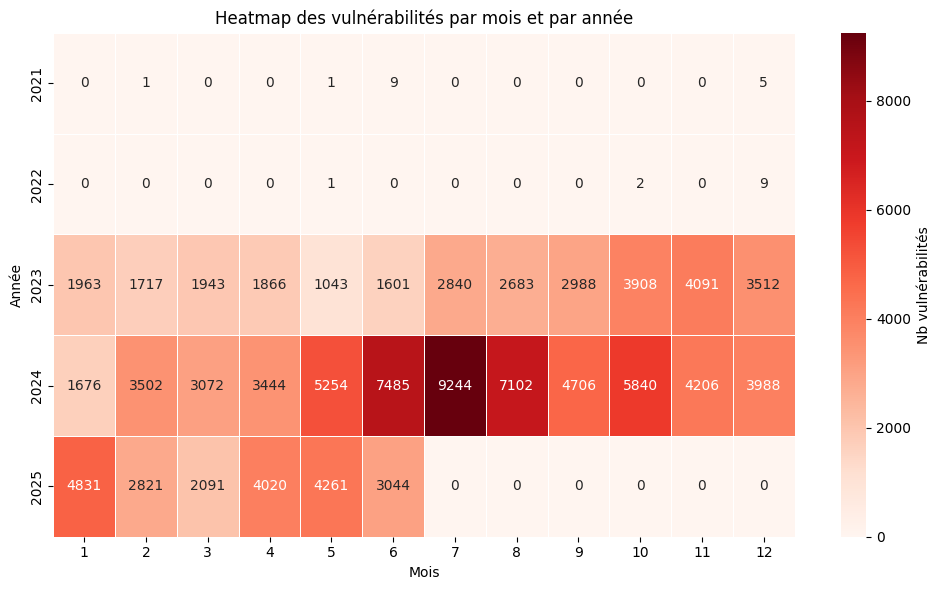

In [55]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="Reds", annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Nb vulnérabilités'})
plt.title("Heatmap des vulnérabilités par mois et par année")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.tight_layout()
plt.show()

# 15. Scatter : product & version

Clean and filter

In [56]:
"""
df_filtered = df.dropna(subset=["Produit", "Versions affectées"])
df_filtered = df_filtered[df_filtered["Produit"] != "n/a"]
top_produits = df_filtered["Produit"].value_counts().head(25).index
top_versions = df_filtered["Versions affectées"].value_counts().head(15).index
df_top_both = df_filtered[
    (df_filtered["Produit"].isin(top_produits)) &
    (df_filtered["Versions affectées"].isin(top_versions))
]
"""


'\ndf_filtered = df.dropna(subset=["Produit", "Versions affectées"])\ndf_filtered = df_filtered[df_filtered["Produit"] != "n/a"]\ntop_produits = df_filtered["Produit"].value_counts().head(25).index\ntop_versions = df_filtered["Versions affectées"].value_counts().head(15).index\ndf_top_both = df_filtered[\n    (df_filtered["Produit"].isin(top_produits)) &\n    (df_filtered["Versions affectées"].isin(top_versions))\n]\n'

In [57]:
df_top_both.loc[:, "Versions affectées"] = df_top_both["Versions affectées"].apply(
    lambda v: v if len(v) <= 20 else v[:17] + "..."
)

NameError: name 'df_top_both' is not defined

Plot

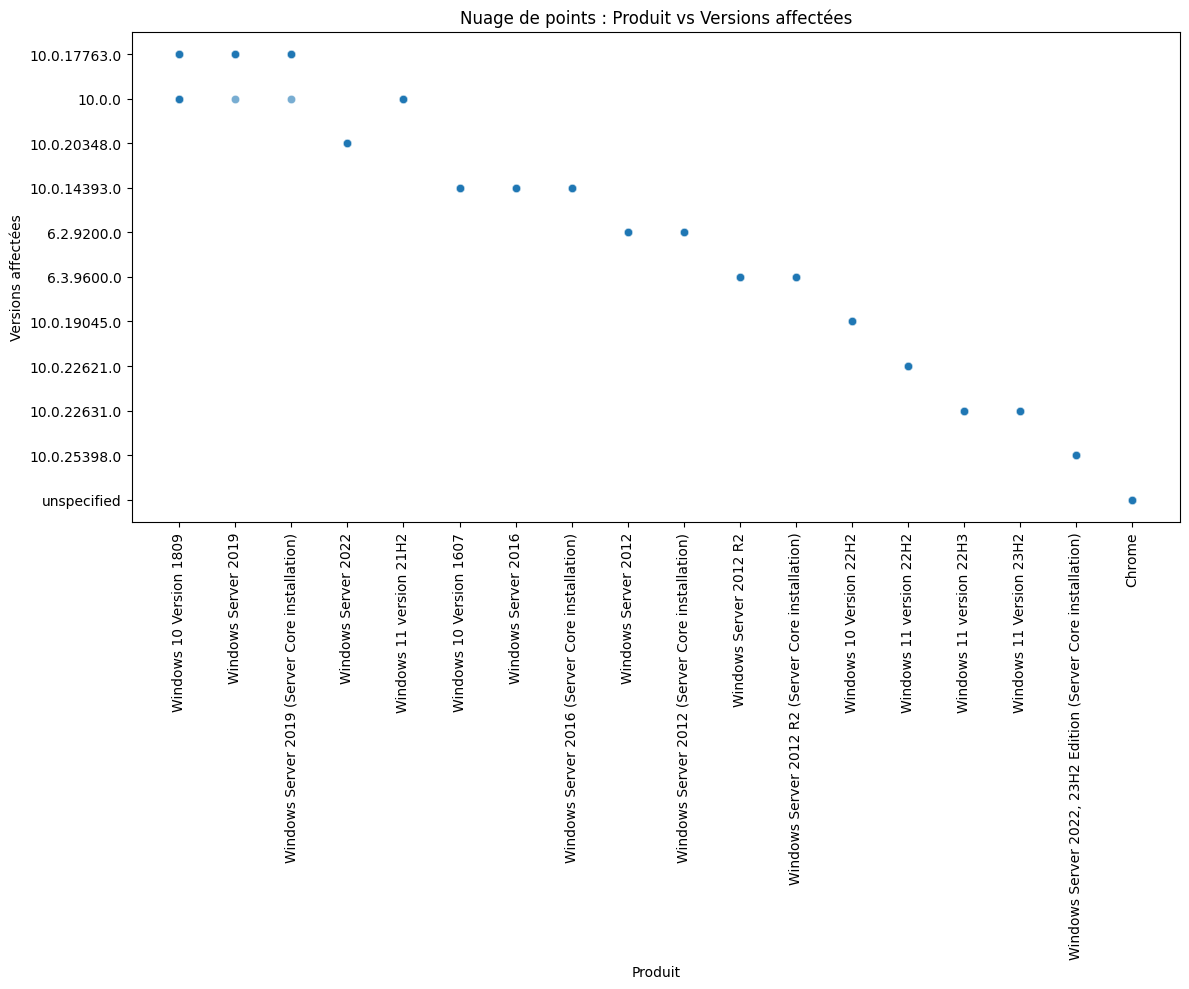

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_top_both, x="Produit", y="Versions affectées", alpha=0.6)

plt.xticks(rotation=90)
plt.title("Nuage de points : Produit vs Versions affectées")
plt.xlabel("Produit")
plt.ylabel("Versions affectées")
plt.tight_layout()
plt.show()

# 16. Bar chart : top 10 versions most impacted by vulnerabilities

Filter

In [ ]:
versions = df["Versions affectées"]
versions = versions[versions != "n/a"]

Shorten the name if too long

In [ ]:
versions_short = versions.apply(lambda v: v if len(v) <= 20 else v[:17] + "...")


In [ ]:
version_counts = versions_short.value_counts().head(10)

Plot

C:\Users\eva2p\AppData\Local\Temp\ipykernel_1228\2037418214.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=version_counts.index, x=version_counts.values, palette="viridis")


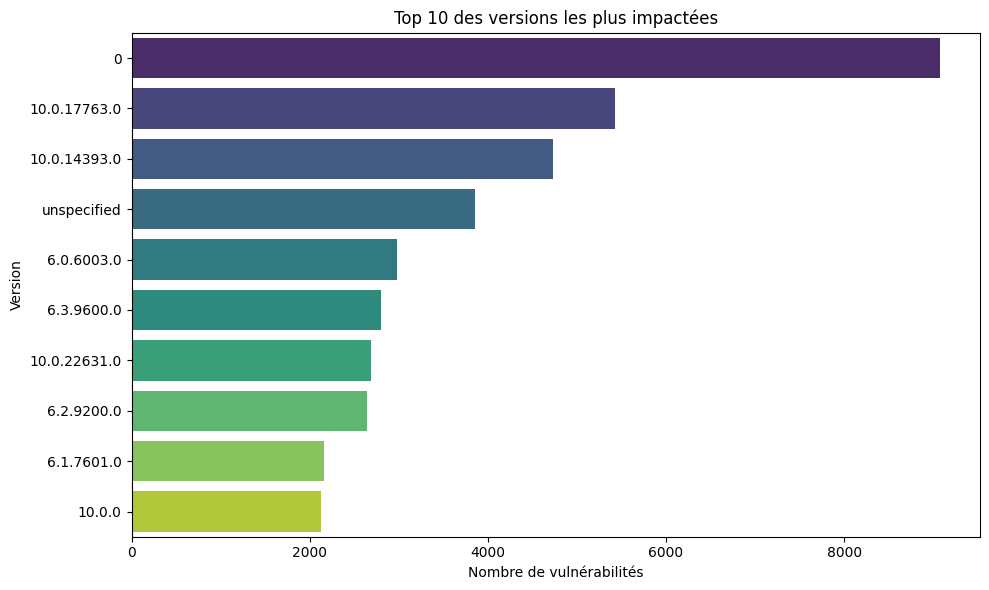

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(y=version_counts.index, x=version_counts.values, palette="viridis")

plt.title("Top 10 des versions les plus impactées")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Version")
plt.tight_layout()
plt.show()

# 17. Temporal evolution of vulnerabilities by bulletin type (Avis/Alertes)

In [ ]:
df['Type'] = df['Type'].str.strip() 
df = df[df['Type'].isin(['Avis', 'Alerte'])]

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Mois'] = df['Date'].dt.to_period('M').astype(str)

Group by month and type (avis/alerte)

In [ ]:
df_evol = df.groupby(['Mois', 'Type']).size().reset_index(name='Nombre')

Sort by chronological month

In [ ]:
df_evol['Mois'] = pd.to_datetime(df_evol['Mois'])
df_evol = df_evol.sort_values('Mois')

Plot

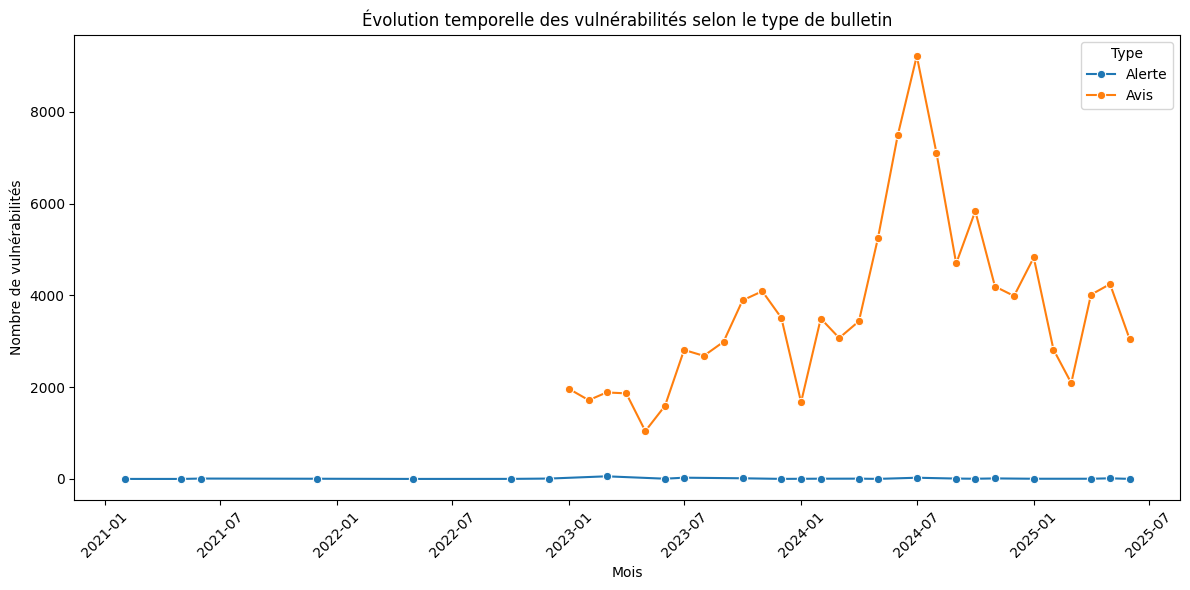

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_evol, x='Mois', y='Nombre', hue='Type', marker='o')
plt.title("Évolution temporelle des vulnérabilités selon le type de bulletin")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 18. Vulnerability by editor and type (alerte/avis)

Group by editor and type

In [ ]:
df_bar = df.groupby(['Éditeur', 'Type']).size().unstack(fill_value=0)

Keep 15 most frequents editors

In [ ]:
df_bar = df_bar.sort_values(df_bar.columns.tolist(), ascending=False).head(15)

Plot

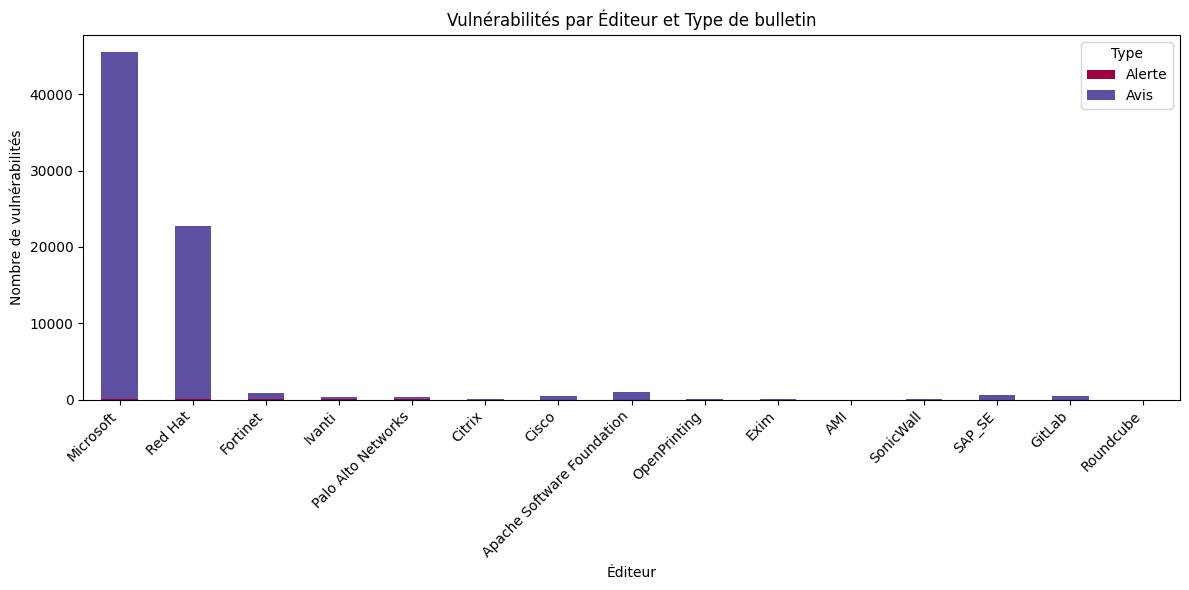

In [ ]:

df_bar.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Spectral')
plt.title("Vulnérabilités par Éditeur et Type de bulletin")
plt.xlabel("Éditeur")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 19. Boxplot - Gravity (CVSS) by bulletin type

Plot

C:\Users\eva2p\AppData\Local\Temp\ipykernel_1228\3635914293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Type", y="CVSS", palette="Set1")


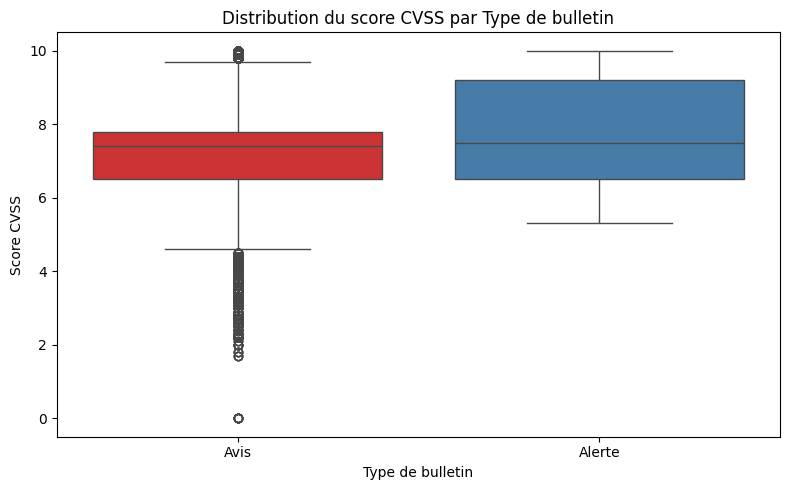

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Type", y="CVSS", palette="Set1")
plt.title("Distribution du score CVSS par Type de bulletin")
plt.xlabel("Type de bulletin")
plt.ylabel("Score CVSS")
plt.tight_layout()
plt.show()

# 20. Heatmap : number of vulnerabilities

Keeping 15 most frequents editors

In [ ]:
top_editeurs = df['Éditeur'].value_counts().head(15).index
df_top = df[df['Éditeur'].isin(top_editeurs)]

Heatmap

In [ ]:
heat_data = df_top.groupby(['Éditeur', 'Base Severity']).size().unstack(fill_value=0)
severity_order = ['Critique', 'Élevée', 'Moyenne', 'Faible', 'Non spécifié']
heat_data = heat_data[[s for s in severity_order if s in heat_data.columns]]

Plot

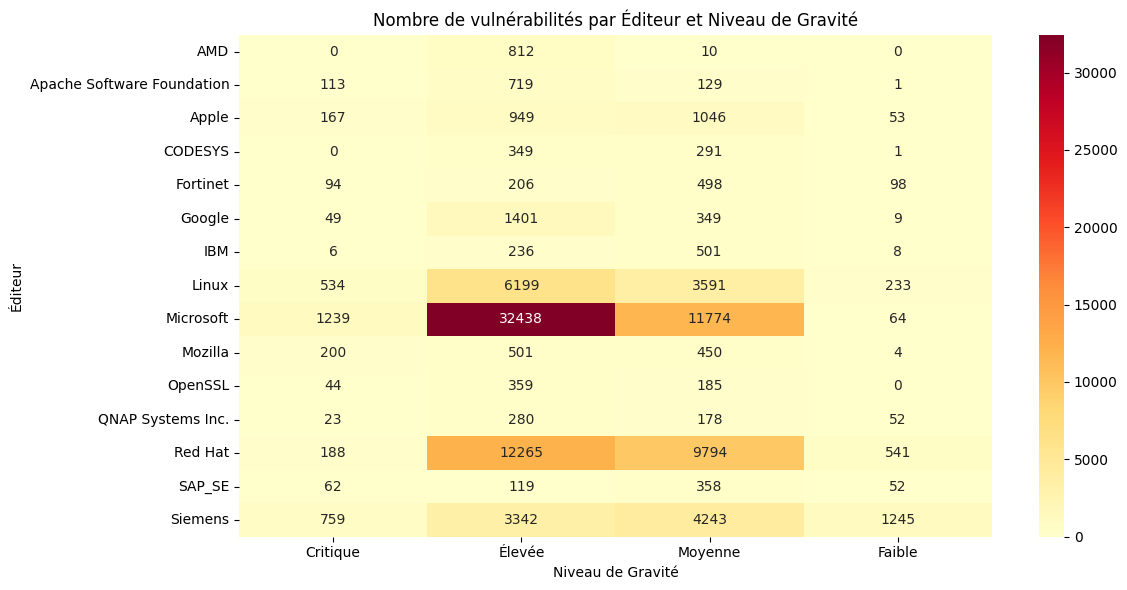

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(heat_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title("Nombre de vulnérabilités par Éditeur et Niveau de Gravité")
plt.xlabel("Niveau de Gravité")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()